GeoPandas can be easily installed using pip install, if the dependencies are available.  It can also be installed using Conda.

In [71]:
!pip install geopandas
import geopandas
import requests
import zipfile
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)

GeoPandas comes with a few built in demonstration maps.  Today I'll use the low-res map of Earth, with country boundaries.  The shapes that make up each boundary are storied in the `geometry` column as polygons defined by geographical coordinates.  Otherwise, Geopandas converts shape files (such as .shp files) into familiar Pandas dataframes with all the powerful functionality and ease of use that comes with them.

In [59]:
earth = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
earth.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000 -16.55522, 179.36414 -16.80135, 178.72506 -17.012..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982, 37.69869 -3.09699, 37.76690 -3.67712, 39.20222 -..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948, -8.68440 27.39574, -8.68729 25.88106, -11.96942 ..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.97421 49.00254, -124.91024 49.98456, -125.62461 50.416..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.00000 49.00000, -117.03121 49.00000, -116.04818 49.000..."


Our `earth` dataframe prints like a dataframe and plots like a map!  GeoPandas takes that `geometry` column and turns it into a lovely map of the nations of the earth, ready for us to fill with markers, colors, or other displays of data.

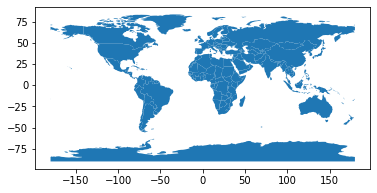

In [60]:
earth.plot()

Let's make a quick Chloropleth! with GeoPandas built in demonstration data.

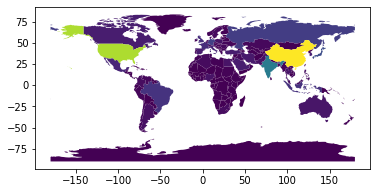

In [61]:
earth.plot(column = 'gdp_md_est')

In order to see more of the power and ease of GeoPandas, let's explore some data about greenhouse gas emissions from 2012 via the [World Bank Data Bank](https://datacatalog.worldbank.org/dataset/world-development-indicators)

The below cell will download a 64MB zip file from "https://datacatalog.worldbank.org/dataset/world-development-indicators" to your computer to create the next dataframe.

In [72]:
url = 'http://databank.worldbank.org/data/download/WDI_csv.zip'
r =  requests.get(url, allow_redirects = True)
open('WDI_csv.zip', 'wb').write(r.content)

65341191

In [62]:
zipdata = zipfile.ZipFile('WDI_csv.zip')
zipdata.extract('WDIData.csv')
indicators = pd.read_csv(zipdata.open('WDIData.csv'))
zipdata.close()
indicators.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Arab World,ARB,Access to clean fuels and technologies for cooking (% of population),EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Access to electricity, rural (% of rural population)",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arab World,ARB,"Access to electricity, urban (% of urban population)",EG.ELC.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,Account ownership at a financial institution or with a mobile-money-service provider (% of popul...,FX.OWN.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.260538,NaN,NaN,30.27713,NaN,NaN,37.165211,NaN,NaN,NaN,NaN


As always, the power of Pandas makes filtering our dataset easy.  The WDIData.csv file has an immense amount of information, over 1400 features for every country, and many on groups of countries such as the `Arab World` group above.  For our purposes we just want the information about climate emissions for individual countries in 2012.  Pandas lets us filter this in a few lines of code.  

In [63]:

indicators = indicators[indicators['Indicator Name'] == 
                    'Total greenhouse gas emissions (kt of CO2 equivalent)']
indicators = indicators.loc[:,['Country Name','Country Code','2012']]
indicators.rename(columns = {'2012':'2012 Total Emissions in 1000s of Kilotons of Equivalent C02'}, inplace = True)
indicators.set_index('Country Code',inplace = True)
indicators.head()

,Country Name,2012 Total Emissions in 1000s of Kilotons of Equivalent C02
Country Code,,
ARB,Arab World,1.908696e+06
CSS,Caribbean small states,9.597684e+04
CEB,Central Europe and the Baltics,9.707336e+05
EAR,Early-demographic dividend,9.734850e+06
EAS,East Asia & Pacific,1.882291e+07


Our data is now in two handy dataframes, with a shared key of country codes. By setting the matching columns, `iso_a3` in the geogatagrame and `Country Code` in the World Bank dataframe, we can join the tables and clean them up to look how we want.  Once again, Pandas makes this a breeze with it's powerful functions and methods. 

In [65]:

earth.set_index('iso_a3',inplace = True)
df = indicators.join(earth, how = 'inner').drop(columns = ['name'])
df = geopandas.GeoDataFrame(df)
df.rename(columns = {'pop_est':'Estimated Population in 1000s',
                    'gdp_md_est':'Estimated GDP in 1000s of US Dollars',
                    'continent':'Continent'},
        inplace = True)
df['Estimated Population in 1000s'] = df['Estimated Population in 1000s']/1000
df['Kiloton C02 Eqivalent Emissions per Person'] = df['2012 Total Emissions in 1000s of Kilotons of Equivalent C02']/df['Estimated Population in 1000s']
geo = df['geometry']
df.drop(columns = ['geometry'],inplace = True)
df.insert(len(df.columns),'geometry',geo)

df.head()

,Country Name,2012 Total Emissions in 1000s of Kilotons of Equivalent C02,Estimated Population in 1000s,Continent,Estimated GDP in 1000s of US Dollars,Kiloton C02 Eqivalent Emissions per Person,geometry
AFG,Afghanistan,18168.860000,34124.811,Asia,64080.0,0.532424,"POLYGON ((66.51861 37.36278, 67.07578 37.35614, 67.83000 37.14499, 68.13556 37.02312, 68.85945 3..."
AGO,Angola,41657.164846,29310.273,Africa,189000.0,1.421248,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4.99127, 12.46800 -5.24836, 12.43669 -5.68430, 12.1..."
ALB,Albania,8898.640911,3047.987,Europe,33900.0,2.919514,"POLYGON ((21.02004 40.84273, 20.99999 40.58000, 20.67500 40.43500, 20.61500 40.11001, 20.15002 3..."
ARE,United Arab Emirates,204888.718962,6072.475,Asia,667200.0,33.740562,"POLYGON ((51.57952 24.24550, 51.75744 24.29407, 51.79439 24.01983, 52.57708 24.17744, 53.40401 2..."
ARG,Argentina,380295.320369,44293.293,South America,879400.0,8.585844,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000 -53.10000, -67.75000 -53.85000, -66.45000 -54.450..."


While we were cleaning up the dataframe, we also created a new column by dividing emissions by population to create `Kiloton C02 Equivalent Emissions per Person` to use in generating maps.

All of our vital data about the countries is now smoothly combined with the `geometry` from the shape file and we are ready to show off how GeoPandas can leverage MatPlotLib to even more!


If you want to save the filtered, joined, and cleaned up dataframe for yourself, you can uncomment and run the below cell.  It's a much smaller file than the one we got from the World Bank!

In [66]:
#df.to_csv('emissions_geodata.csv', index = False) 

GeoPandas smoothly leverages the graphing abilities of MatPlotLib, and some familiarity that that library will let us customize our maps with MatPlotLib functions.  

Below, we create a new figure with two subplots and configure the all of them to our liking.  Then we feed those into GeoPandas' built in `.plot()` method to plot our two choloropleth maps to compare.  

Once in the `.plot()` method, we can pass keywords to further customize our maps, setting color schemes, legend settings, and even tell GeoPandas how to handle missing data.  In this case, we used `missing_kwds` to tell Geopandas to just set countries with missing data to grey.  

As you can see, GeoPandas lets us combine it's own interaction apis, as well as artist and figure layer interactions to customize our maps.  There are are thousands of ways to customize maps, and [here](https://matplotlib.org/users/dflt_style_changes.html#colormap) are just a few of the global settings you can tweak in MatPlotLib.

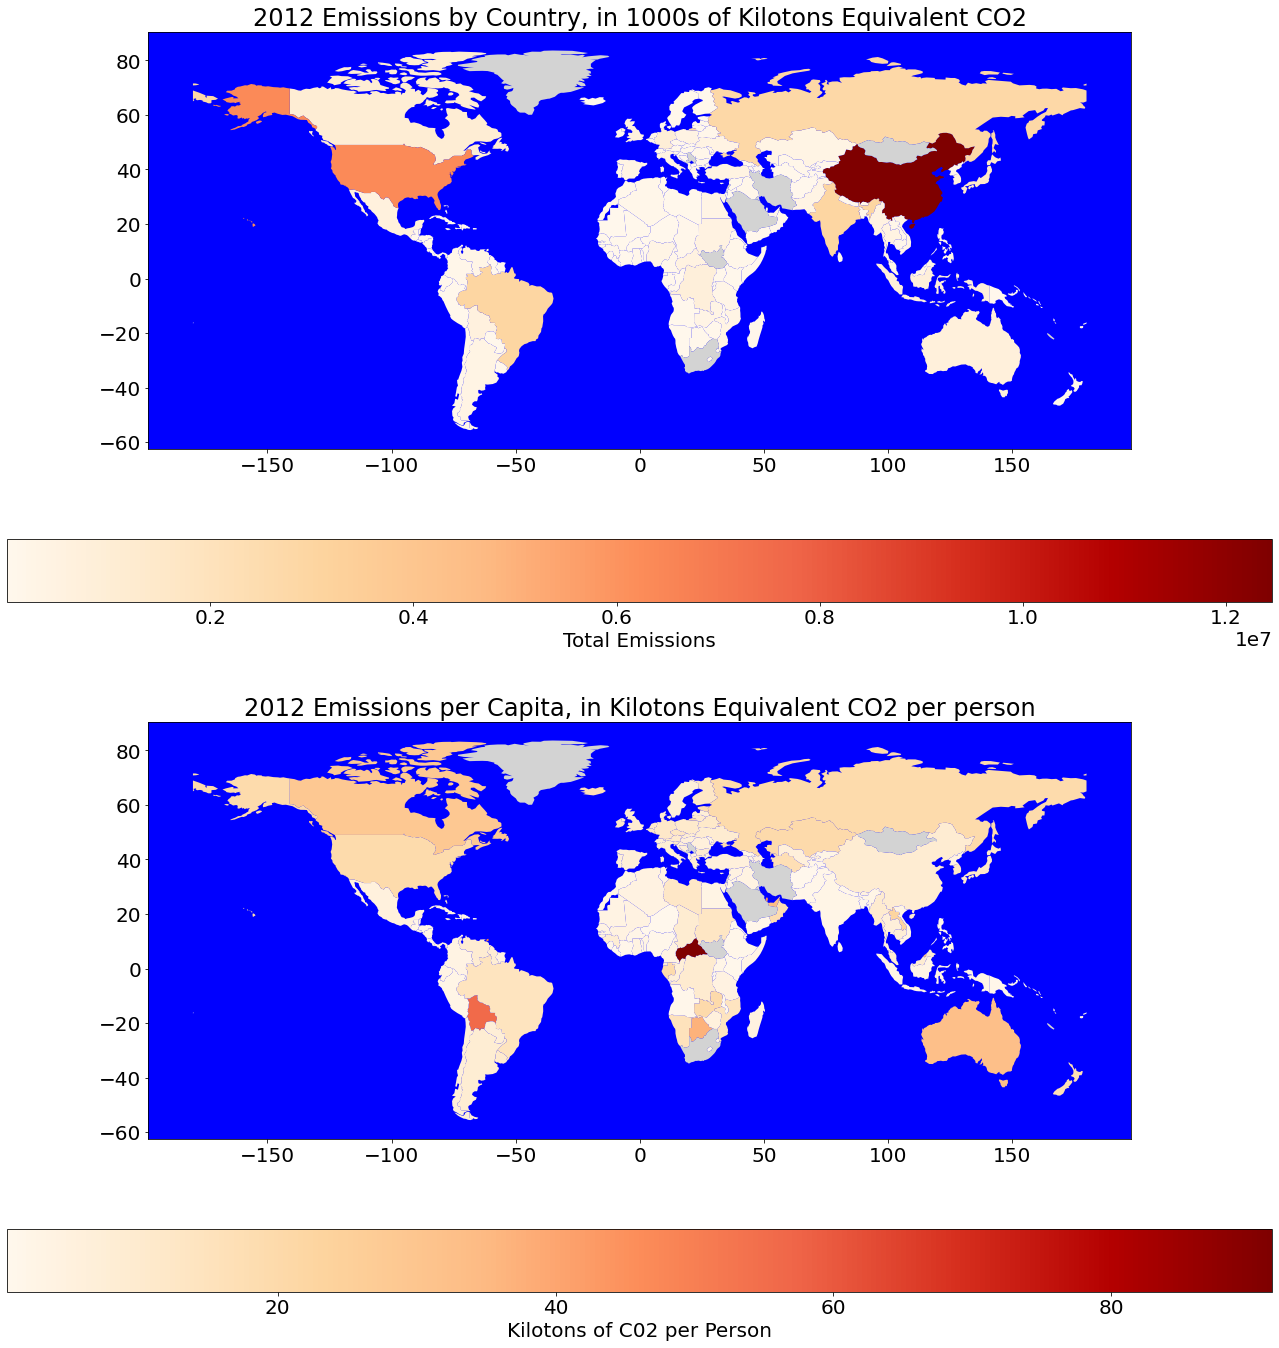

<Figure size 2880x1440 with 0 Axes>

In [87]:
# change the global fontsize for plt
plt.rcParams.update({'font.size':20})

# create the figure and subplot axes
fig, axes = plt.subplots(2,1, figsize = (20,20))
plt.figure(figsize = (40,20))
fig.tight_layout(pad = 3.0)

# Set the background and labels
axes[0].set_facecolor('blue')
axes[1].set_facecolor('blue')
axes[0].set_title('2012 Emissions by Country, in 1000s of Kilotons Equivalent CO2')
axes[1].set_title('2012 Emissions per Capita, in Kilotons Equivalent CO2 per person')


df.plot(column = '2012 Total Emissions in 1000s of Kilotons of Equivalent C02', 
        legend = True, 
        legend_kwds = {'label':'Total Emissions',
                       'orientation':'horizontal'},
        ax = axes[0], 
        figsize = (40,20), 
        cmap = 'OrRd', 
        missing_kwds = {'color': 'lightgrey'}
       )

df.plot(column = 'Kiloton C02 Eqivalent Emissions per Person', 
        legend = True, 
        legend_kwds = {'label':'Kilotons of C02 per Person', 
                       'orientation':'horizontal'
                       },        
        ax = axes[1], 
        figsize = (40,20), 
        cmap = 'OrRd',
        missing_kwds = {'color': 'lightgrey'}
       )


fig.savefig('emission_maps.png')

Thanks for taking a look at my notebook on getting started with GeoPandas!  I hope you take these simple ideas and run with them to inform and entertain yourself and your audiences.